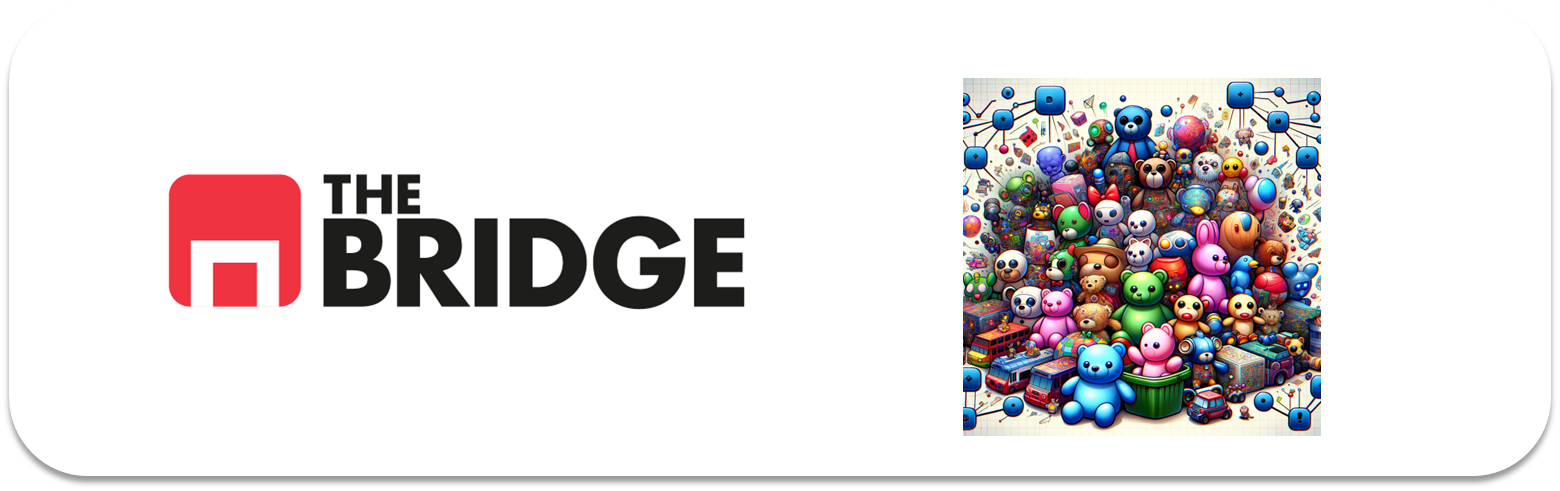

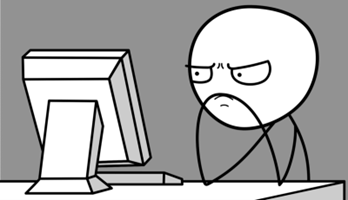

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
# Cargamos CSV 
df = pd.read_csv("./data/empowering_drinks.csv", sep="|")

df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [5]:
df.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


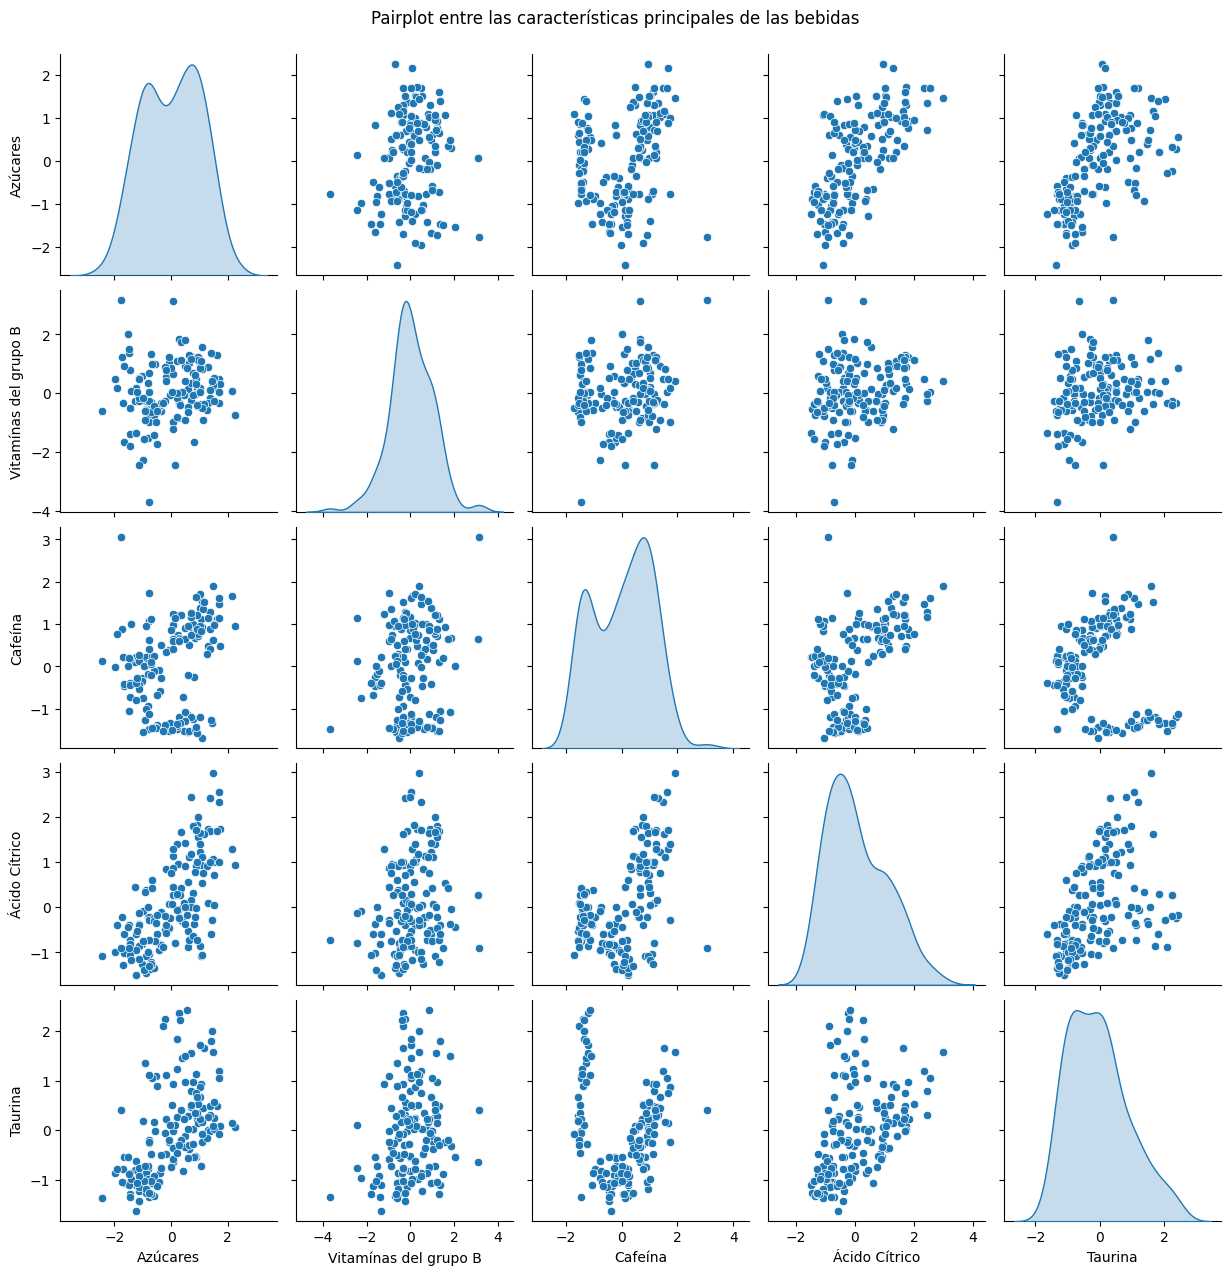

In [6]:
# Cruzamos cada variable entre ellas (pares) para observar como se comportan sus gráficos de dispersion
sns.pairplot(df, diag_kind="kde")
plt.suptitle("Pairplot entre las características principales de las bebidas", y=1.02)
plt.show()

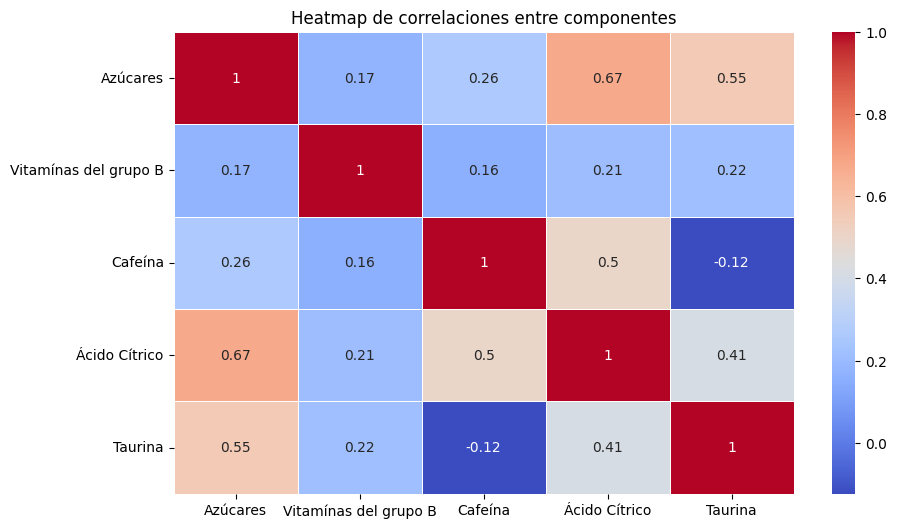

In [7]:
# Ahora hacemos matriz de correlación y heatmap
plt.figure(figsize=(10,6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap de correlaciones entre componentes")
plt.show()

Estandarizamos las variables con el siguiente código. Tanto k-means como DBSCAN son muy sensibles a la escala por eso lo hacemos

In [9]:
# Inicializamos el escalador y lo utilizamos para crear nuevo DF 
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Mostramos el dataframe ya escalado que vamos a usar para el modelado.
df_scaled.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.465925,0.196207,0.957824,0.927289,0.317612
1,0.221992,-0.871612,0.667526,0.879813,-0.267608
2,0.173684,1.079919,1.132002,1.307094,0.336190
3,1.635003,0.453956,1.373917,2.240782,1.320844
4,0.270301,1.816346,0.599790,-0.117176,-0.295475


#### Empezamos con el modelado de DBSCAN y luego seguiremos con K-MEANS

In [12]:
# Entrenar el modelo DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=4)  # Probar diferentes valores de eps y min_samples
clusters_dbscan = dbscan.fit_predict(df_scaled)

# Agregar los clusters encontrados al DataFrame original para análisis posterior
df['Cluster_DBSCAN'] = clusters_dbscan

# Visualizar resultados DBSCAN
print(df['Cluster_DBSCAN'].value_counts())

Cluster_DBSCAN
 0    50
 2    46
 3    30
-1    23
 1     4
Name: count, dtype: int64


#### Hacemos ahora el modelado de K-MEANS

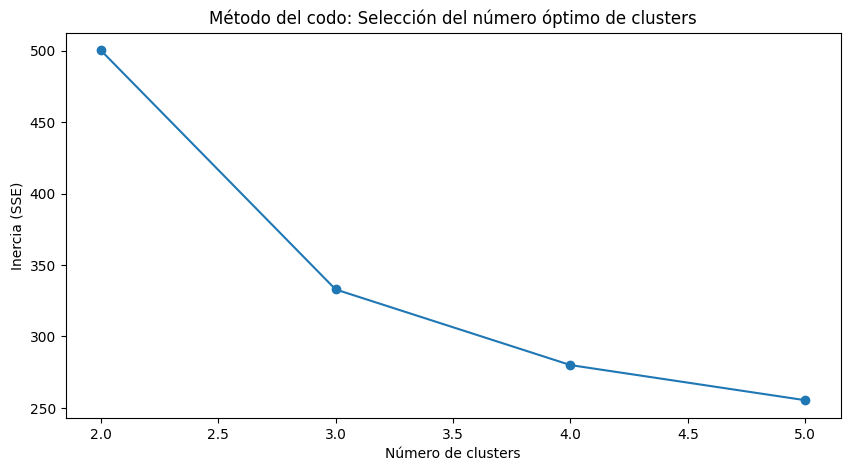

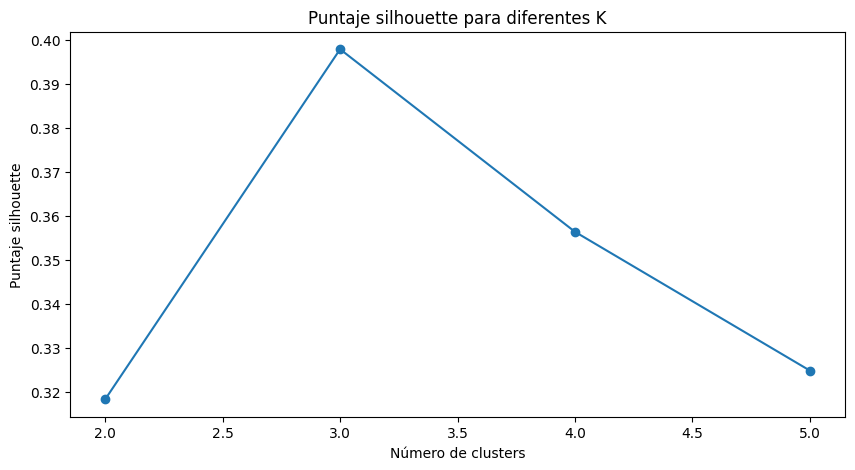

Cluster_KMeans
2    58
0    58
1    37
Name: count, dtype: int64


In [15]:
# Probamos diferentes valores de K para seleccionar el número de clusters óptimo
sse = []
silhouette_scores = []

for k in range(2, 6):  # Probar entre 2 y 5 clusters 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)  # Inertia para el método del codo
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))  # Puntaje silhouette

# Gráfico para el método del codo
plt.figure(figsize=(10,5))
plt.plot(range(2, 6), sse, marker='o')
plt.title("Método del codo: Selección del número óptimo de clusters")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia (SSE)")
plt.show()
# Gráfico para el método de puntaje silhoutte
plt.figure(figsize=(10,5))
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title("Puntaje silhouette para diferentes K")
plt.xlabel("Número de clusters")
plt.ylabel("Puntaje silhouette")
plt.show()

# Una vez sabemos cual es el número óptimo de clusters, entrenamos el modelo K-means
kmeans = KMeans(n_clusters=3, random_state=42)  # Seleccionar el K óptimo
df['Cluster_KMeans'] = kmeans.fit_predict(df_scaled)

# Visualizar los clusters encontrados
print(df['Cluster_KMeans'].value_counts())

### Visualización de los clusters

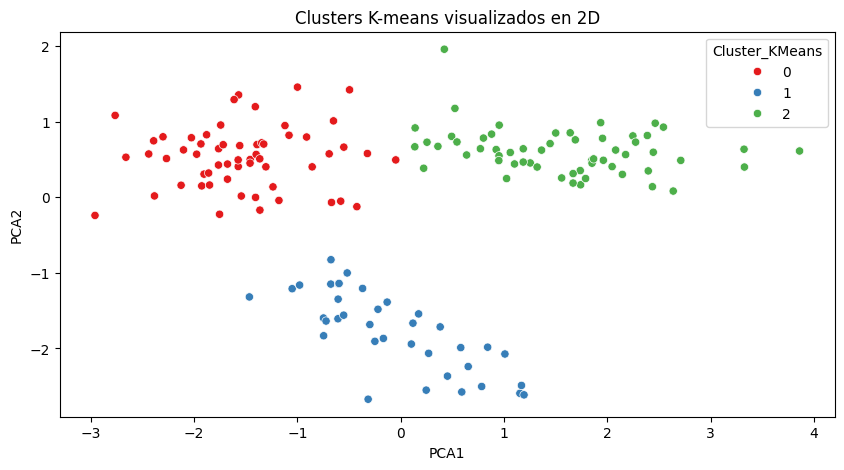

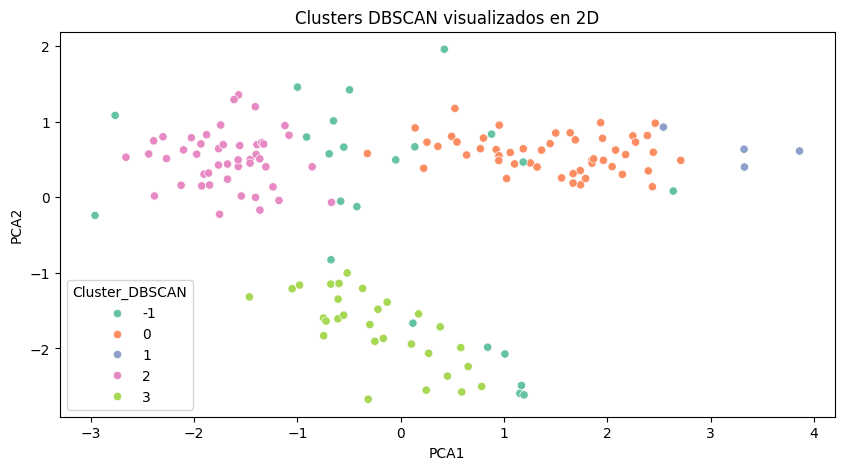

In [17]:
# Reducir las dimensiones a 2D para visualización
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convertir el resultado a DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster_DBSCAN'] = df['Cluster_DBSCAN']
df_pca['Cluster_KMeans'] = df['Cluster_KMeans']

# Visualización de los clusters encontrados con K-means
plt.figure(figsize=(10,5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', data=df_pca, palette='Set1')
plt.title("Clusters K-means visualizados en 2D")
plt.show()

# Visualización de los clusters encontrados con DBSCAN
plt.figure(figsize=(10,5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_DBSCAN', data=df_pca, palette='Set2')
plt.title("Clusters DBSCAN visualizados en 2D")
plt.show()

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [19]:
df_experiments = pd.read_csv("./data/new_experiments.csv", sep="|")
df_experiments.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


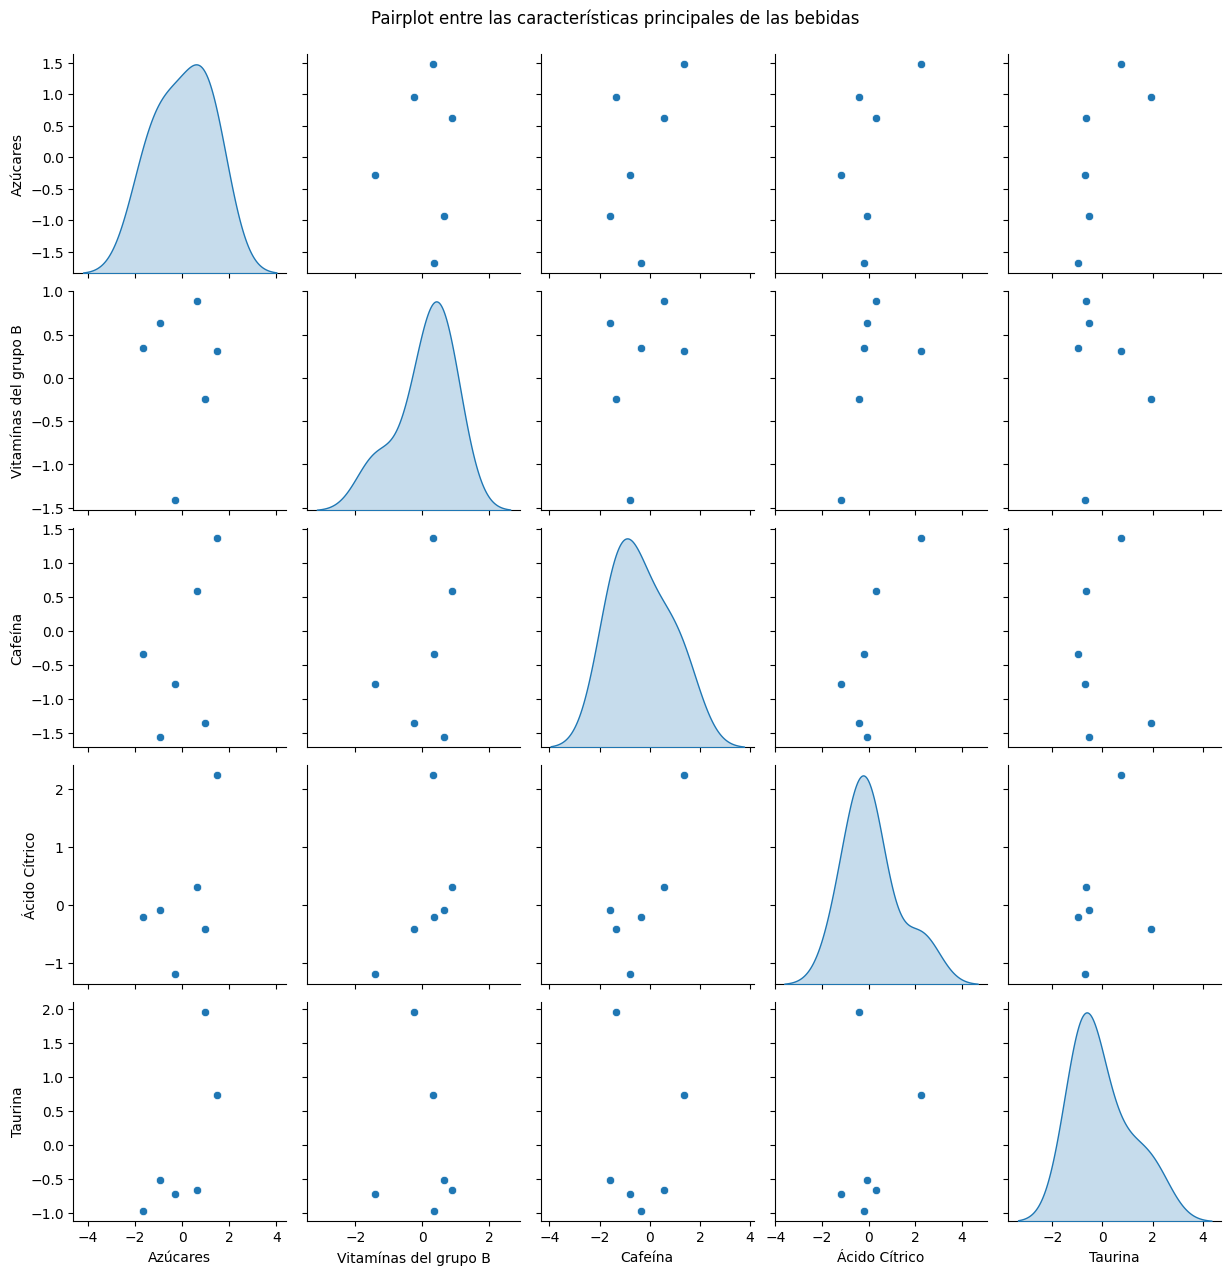

In [20]:
# Cruzamos cada variable entre ellas (pares) para observar como se comportan sus gráficos de dispersion
sns.pairplot(df_experiments, diag_kind="kde")
plt.suptitle("Pairplot entre las características principales de las bebidas", y=1.02)
plt.show()

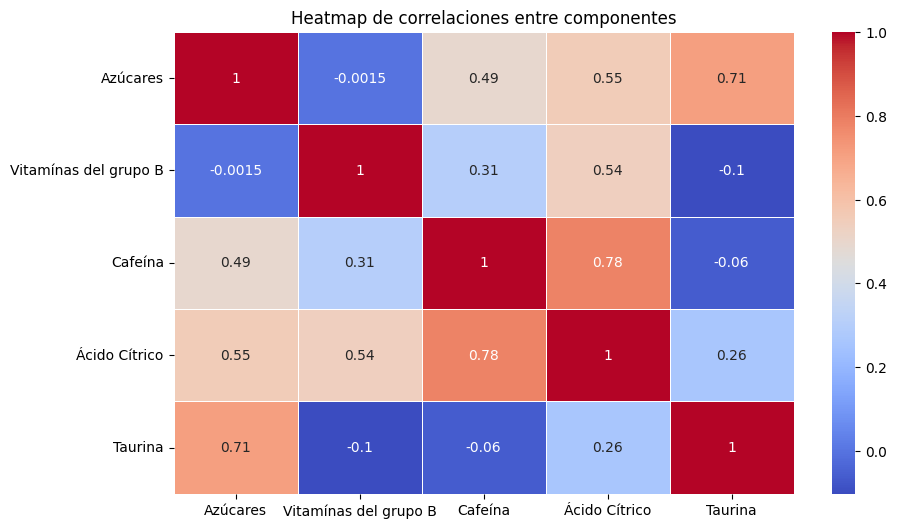

In [21]:
# Ahora hacemos matriz de correlación y heatmap
plt.figure(figsize=(10,6))
correlation_matrix = df_experiments.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap de correlaciones entre componentes")
plt.show()

In [22]:

# Escalamos los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_experiments)

In [25]:
from sklearn.cluster import KMeans

# Definir el número de clusters, este valor debe coincidir con lo que hayas usado antes
num_clusters = 3  # Ajusta este valor según lo que hayas utilizado
kmeans = KMeans(n_clusters=num_clusters)

# Ajustar el modelo y predecir los clusters
clusters = kmeans.fit_predict(scaled_data)

# Añadir los resultados al dataframe original
df_experiments['Cluster'] = clusters

# Visualizar los resultados
print(df_experiments.head())


   Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.481555               0.305159  1.366128       2.239039  0.731870        2
1  0.616869               0.890014  0.583034       0.312420 -0.665332        0
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782        0
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240        0
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583        0


In [26]:
# Guardar los resultados en un archivo CSV
df_experiments.to_csv('./data/segmented_experiments.csv', index=False)


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.